In [2]:
import pandas as pd

df = pd.read_csv('drive/MyDrive/datasets/pizza_sales.csv')
df.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1,1,hawaiian_m,1,01-01-2015,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2,2,classic_dlx_m,1,01-01-2015,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,3,2,five_cheese_l,1,01-01-2015,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
3,4,2,ital_supr_l,1,01-01-2015,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza
4,5,2,mexicana_m,1,01-01-2015,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza


In [15]:
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error

df['order_date'] = pd.to_datetime(df['order_date'], dayfirst=True)
daily_revenue = df.groupby('order_date')['total_price'].sum().reset_index()

data = daily_revenue.rename(columns={'order_date': 'ds', 'total_price': 'y'})
print(data)

            ds        y
0   2015-01-01  2713.85
1   2015-01-02  2731.90
2   2015-01-03  2662.40
3   2015-01-04  1755.45
4   2015-01-05  2065.95
..         ...      ...
353 2015-12-27  1419.00
354 2015-12-28  1637.20
355 2015-12-29  1353.25
356 2015-12-30  1337.80
357 2015-12-31  2916.00

[358 rows x 2 columns]


In [16]:
train_size = int(len(data) * 0.8)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

model = Prophet(daily_seasonality=True, yearly_seasonality=True)
model.fit(train_data)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpsn69iqrf/ai6p4nmh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsn69iqrf/re6i9m9p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6281', 'data', 'file=/tmp/tmpsn69iqrf/ai6p4nmh.json', 'init=/tmp/tmpsn69iqrf/re6i9m9p.json', 'output', 'file=/tmp/tmpsn69iqrf/prophet_modelhh22w144/prophet_model-20250405204304.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:43:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:43:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [17]:
future = model.make_future_dataframe(periods=len(test_data))
forecast = model.predict(future)

merged = pd.merge(test_data, forecast[['ds', 'yhat']], on='ds', how='left')
merged = merged.dropna()

print(merged)

           ds        y         yhat
0  2015-10-18  1795.30  2338.699924
1  2015-10-20  2437.15  2785.052961
2  2015-10-21  2460.50  2817.852161
3  2015-10-22  2400.90  2974.249822
4  2015-10-23  2610.65  3364.680706
..        ...      ...          ...
64 2015-12-23  2244.30  2643.642137
65 2015-12-24  2137.85  2698.924116
66 2015-12-26  1643.05  2626.239249
67 2015-12-27  1419.00  2093.211527
68 2015-12-28  1637.20  2359.697993

[69 rows x 3 columns]


📊 Середня абсолютна помилка (MAE): 568.33
📉 тонічсть моделі: 74.64%


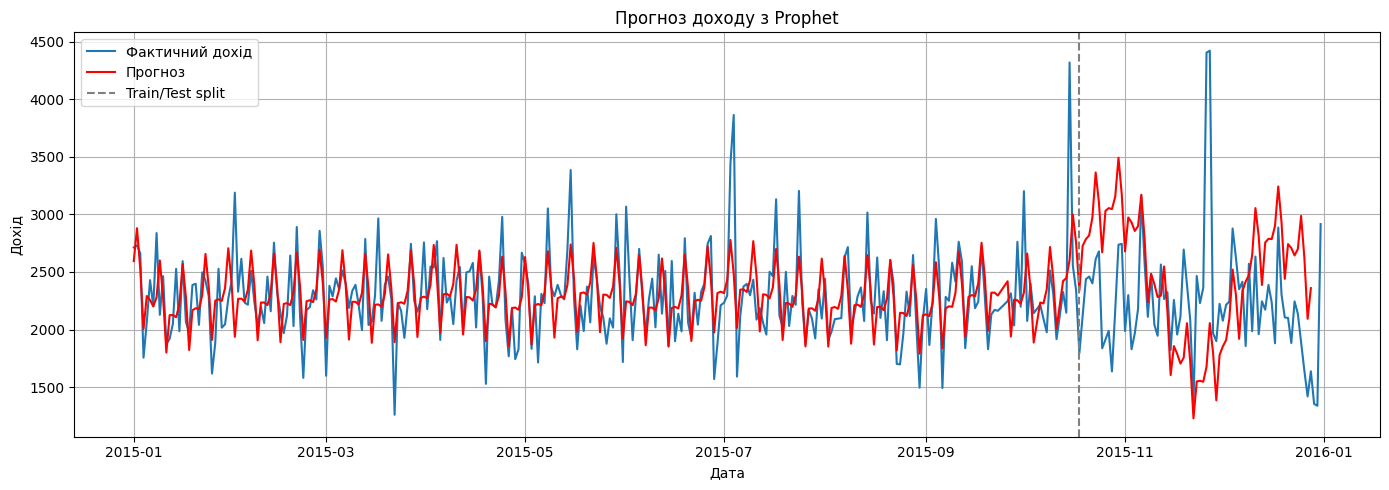

In [21]:
y_true = merged['y'].values
y_pred = merged['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
mape = (abs(y_true - y_pred) / y_true).mean() * 100

print(f"📊 Середня абсолютна помилка (MAE): {mae:.2f}")
print(f"📉 тонічсть моделі: {100 - mape:.2f}%")

plt.figure(figsize=(14, 5))
plt.plot(data['ds'], data['y'], label='Фактичний дохід')
plt.plot(forecast['ds'], forecast['yhat'], label='Прогноз', color='red')
plt.axvline(data['ds'].iloc[train_size], color='gray', linestyle='--', label='Train/Test split')
plt.title('Прогноз доходу з Prophet')
plt.xlabel('Дата')
plt.ylabel('Дохід')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()